In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!pip install -U -q PyDrive

In [1]:
import os, cv2
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf

In [2]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/CoNSeP')
try:
  os.makedirs(local_download_path)
except: pass

def load_files_to_colab(folder_id, des_path):
  # 2. Auto-iterate using the query syntax
  #    https://developers.google.com/drive/v2/web/search-parameters
  file_list = drive.ListFile(
      {'q': "'{}' in parents".format(folder_id)}).GetList()

  local_download_path = os.path.expanduser('~/CoNSeP/{}'.format(des_path))
  try:
    os.makedirs(local_download_path)
  except: pass

  for f in file_list:
    # 3. Create & download by id.
    #print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(local_download_path, f['title'])
    #print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

In [3]:
import tqdm 
files_to_load = {
    'Test/Images': '1bvUzfYfj-_6vXMYMz-slJLpABUBNzqAZ',
    'Test/Labels': '1NUbVnkXZ4tccVm6olTohhoZnqNdc3gKm',
    'Test/Overlay': '1qUvAQDvsGpwqX6fTlLnqQSwseHA1CHt8',
    'Train/Images': '1N2N40aS9oSk8F1ruWxMXEL-r914t9i9c',
    'Train/Labels': '1HREv-wEWg2oln_vicfq3A1CKmlgtPEdK',
    'Train/Overlay': '1ZbPYYr8tJRQer6UnJN3wWpxX2sMv3Ibo'
}

for des_path, folder_id in tqdm.tqdm(files_to_load.items()):
  load_files_to_colab(folder_id, des_path)

100%|██████████| 6/6 [03:26<00:00, 34.44s/it]


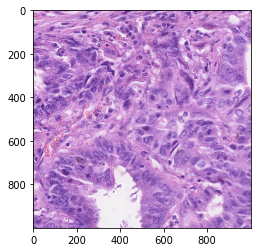

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('/root/CoNSeP/Train/Images/train_3.png')
  
# Input Images
plt.imshow(img)

In [5]:
img.shape

(1000, 1000, 3)

# Read data

In [6]:
import scipy.io
# loead from file to dict
data = {
    'train_x': [mpimg.imread('/root/CoNSeP/Train/Images/train_{}.png'.format(i)) for i in range(1,28)],
    'train_y': np.array([scipy.io.loadmat('/root/CoNSeP/Train/Labels/train_{}.mat'.format(i))['type_map'] for i in range(1, 28)]),
    'test_x': [mpimg.imread('/root/CoNSeP/Test/Images/test_{}.png'.format(i)) for i in range(1,15)],
    'test_y': np.array([scipy.io.loadmat('/root/CoNSeP/Test/Labels/test_{}.mat'.format(i))['type_map'] for i in range(1, 15)])
}

In [7]:
data['train_x'][7].shape

(1000, 1000, 3)

In [8]:
# remove 4th channel from images
def rm_4th_chnl(dataset):
  for i in range(len(dataset)):
    img = dataset[i]
    # In case of grayScale images the len(img.shape) == 2
    if len(img.shape) > 2 and img.shape[2] == 4:
      #convert the image from RGBA2RGB
      dataset[i] = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR) 
  return np.array(dataset)

In [9]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [10]:
# resize images
def resize_image(data):
    img = data
    print(len(img))
    print('Original size',img[0].shape)
    # setting dim of the resize
    height = 256
    width = 256
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[0].shape)
    
    # Visualizing one of the images in the array
    original = res_img[0]
    display_one(original)

    return np.array(res_img)

27
Original size (1000, 1000, 3)
RESIZED (256, 256, 3)


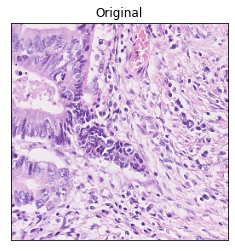

27
Original size (1000, 1000)
RESIZED (256, 256)


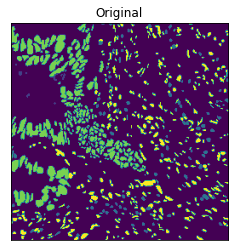

14
Original size (1000, 1000, 3)
RESIZED (256, 256, 3)


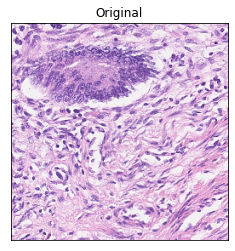

14
Original size (1000, 1000)
RESIZED (256, 256)


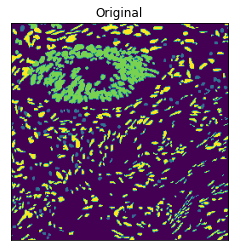

In [11]:
data['train_x'] =  resize_image(rm_4th_chnl(data['train_x']))
data['train_y'] =  to_categorical(resize_image(data['train_y']))
data['test_x'] =  resize_image(rm_4th_chnl(data['test_x']))
data['test_y'] = to_categorical(resize_image(data['test_y']))

In [12]:
data['train_x'][7].shape

(256, 256, 3)

In [13]:
data['train_y'][7].shape

(256, 256, 8)

# Segmentation Model

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models
#!pip uninstall segmentation-models
#!pip install -U segmentation-models
#!pip install -q h5py

In [37]:
import tensorflow.keras
SM_FRAMEWORK = tensorflow.keras
import segmentation_models as sm
sm.set_framework('tf.keras')
tensorflow.keras.backend.set_image_data_format('channels_last')

In [24]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val = data['train_x'], data['train_y'], data['test_x'], data['test_y']

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
#model.compile(
#    'Adam',
#    loss=sm.losses.binary_crossentropy,
#    metrics=[sm.metrics.f1_score],
#)

In [47]:
#y_train = np.asarray(y_train).astype('float32').reshape((y_train.shape[0],-1))
#y_val = np.asarray(y_val).astype('float32').reshape((y_val.shape[0],-1))

In [63]:
# define optomizer
optim = tensorflow.keras.optimizers.Adam(0.001)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [26]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tensorflow.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tensorflow.keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
          x=x_train,
          y=y_train,
          batch_size=32,
          epochs=20,
          callbacks=callbacks,
          validation_data=(x_val, y_val)
        )

In [ ]:
from segmentation_models import Unet, FPN
from segmentation_models.utils import set_trainable
model = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=8, activation='softmax')
#model.compile(optim, sm.losses.categorical_crossentropy, [sm.metrics.f1_score])
model.compile(optim, sm.losses.categorical_focal_dice_loss, [sm.metrics.f1_score])

# pretrain model decoder
model.fit(x_train, y_train, epochs=50)

#sm.recompile = False

# release all layers for training
set_trainable(model, recompile=False) # set all layers trainable and recompile model

# continue training
history = model.fit(x_train, y_train, epochs=50)

KeyError: ignored

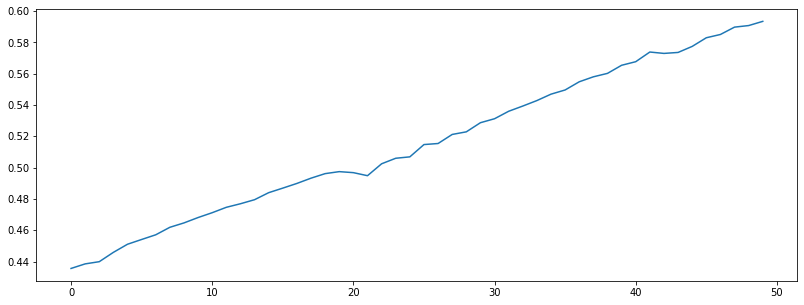

In [75]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
pip install Keras-Applications
pip install image-classifiers
pip install efficientnet==1.0.0

     |████████████████████████████████| 50 kB 2.7 MB/s 


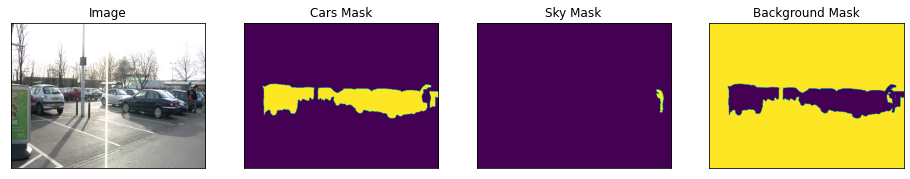

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'pedestrian'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

In [ ]:
x_train.shape

TensorShape([27, 1000, 1000, 3])